# SignalFilter

Based on the notebook here: https://nbviewer.jupyter.org/github/pycroscopy/papers/blob/master/HTML/SPM/AFM/gIV_sIV_Nat_Comm_2017.html

## Import packages:

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from shutil import copyfile
import tempfile

from dask_signal_filter import SignalFilter
import fft

## Make a (temporary) copy of the original file:

In [2]:
orig_path = 'pzt_nanocap_6_just_translation_copy.h5'

with tempfile.TemporaryDirectory() as tmp_dir:
    h5_path = tmp_dir + 'giv.h5'
    copyfile(orig_path, h5_path)

## Open the temporary HDF5 file:

In [3]:
h5_f = h5py.File(h5_path, mode='r+')
# Not necessary I think but Chris used it
h5_f.atomic = True # This doesn't seem to make any difference

h5_grp = h5_f['Measurement_000/Channel_000']
h5_main = h5_grp['Raw_Data']
# h5_main = usid.USIDataset(h5_main)

## Setting up the scientific process here:

In [4]:
samp_rate = h5_grp.attrs['IO_samp_rate_[Hz]']
num_spectral_pts = h5_main.shape[1]

frequency_filters = [fft.LowPassFilter(num_spectral_pts, samp_rate, 10E+3)]
noise_tol = 1E-6

sig_filt = SignalFilter(h5_main, frequency_filters=frequency_filters,
                           noise_threshold=noise_tol, write_filtered=True,
                           write_condensed=False, num_pix=1, 
                        verbose=False)

# Set verbose=True to get more information on your print statements

/Users/syz/PycharmProjects/pyUSID/pyUSID/io/usi_data.py:148: UserWarning: This dataset does not have an N-dimensional form
  warn('This dataset does not have an N-dimensional form')


Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file


## Calling the compute function here:

In [5]:
h5_filt_grp = sig_filt.compute()

/Users/syz/PycharmProjects/pyUSID/pyUSID/io/hdf_utils/simple.py:981: UserWarning: In the future write_ind_val_dsets will default to requiring dimensions to be arranged from slowest to fastest varying
  warn('In the future write_ind_val_dsets will default to requiring dimensions to be arranged from slowest to fastest varying')
/Users/syz/PycharmProjects/pyUSID/pyUSID/io/usi_data.py:148: UserWarning: This dataset does not have an N-dimensional form
  warn('This dataset does not have an N-dimensional form')


	This class (likely) supports interruption and resuming of computations!
	If you are operating in a python console, press Ctrl+C or Cmd+C to abort
	If you are in a Jupyter notebook, click on "Kernel">>"Interrupt"
	If you are operating on a cluster and your job gets killed, re-run the job to resume

Rank 0 finished parallel computation
Rank 0 - 100% complete. Time remaining: 0.0 msec
Finished processing the entire dataset!


## Preparing to visualize:

In [6]:
bias_vec = 6 * np.sin( np.linspace(0, 2*np.pi, 500))
h5_filt = h5_filt_grp['Filtered_Data']
row_ind = 40
filt_row = h5_filt[row_ind].reshape(-1, bias_vec.size)
raw_row = h5_main[row_ind].reshape(-1, bias_vec.size)

## Is the black line smoother than the red line?

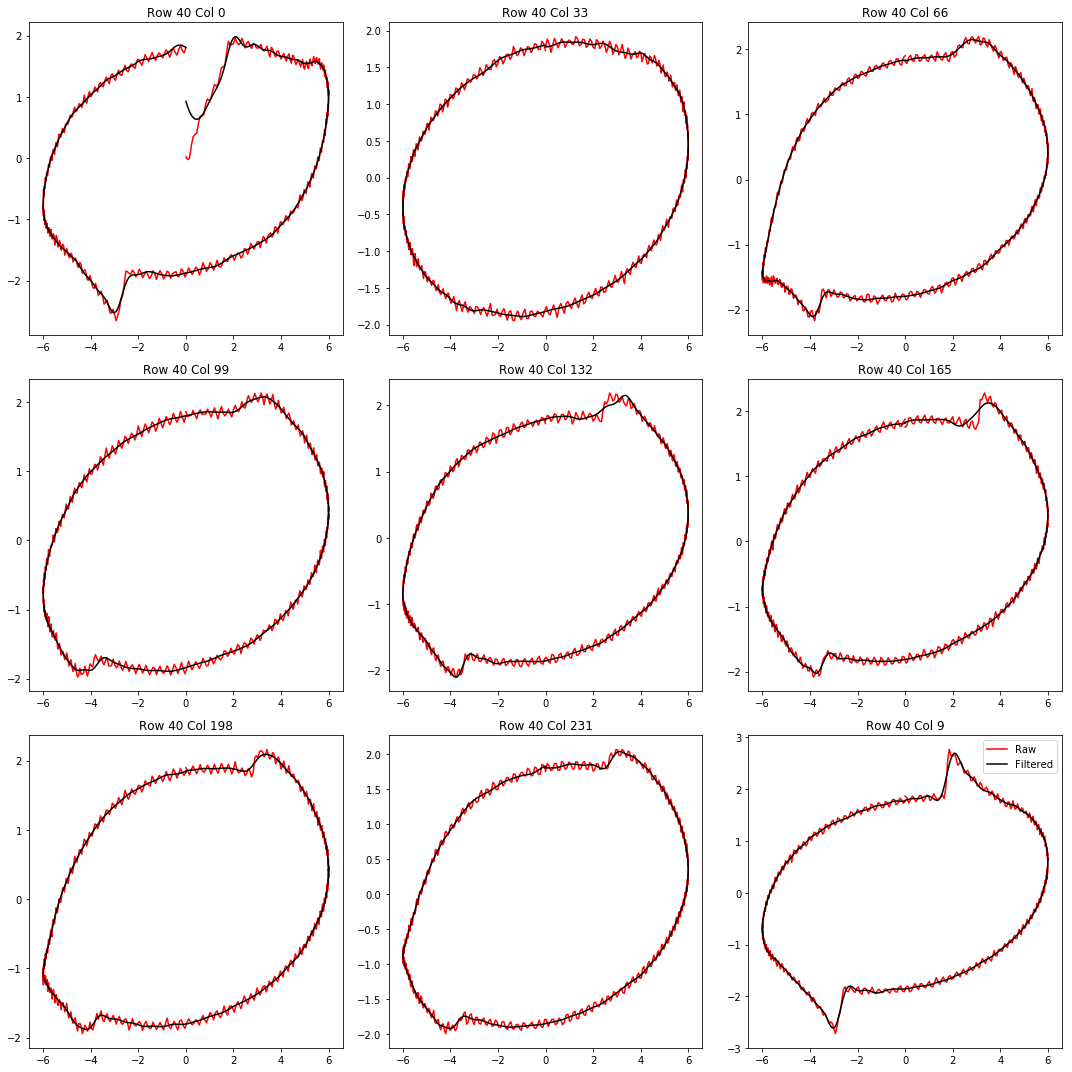

In [7]:
plots_on_side = 3

fig, axes = plt.subplots(nrows=plots_on_side, ncols=plots_on_side, figsize=(15, 15))
for axis, col_ind in zip(axes.flat, np.linspace(0, filt_row.shape[0]-1, plots_on_side ** 2, dtype=np.uint8)):
    axis.plot(bias_vec, raw_row[col_ind], 'r')
    axis.plot(bias_vec, filt_row[col_ind], 'k')
    axis.set_title('Row {} Col {}'.format(row_ind, col_ind))
axis.legend(['Raw', 'Filtered'])
fig.tight_layout()

## Closing up:

In [7]:
h5_f.close()